In [2]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.datasets
from mylib.PlotUtil import PlotLossAndAccuracy, PlotTupleDataSet, generate_cmap

data = sklearn.datasets.load_iris()

In [38]:
data.data[0:20]
data.target[0:20]
data.feature_names


array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3]])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## データセットの解析

分類を始める前にデータがどのような分布になっているのか見る

x - 花びらの長さ 
y - 花びらの幅


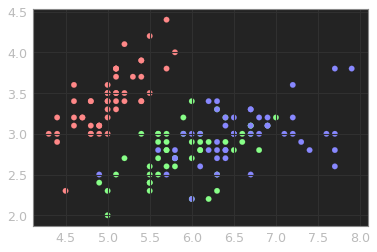

x - 花びらの長さ 
y - がくの長さ


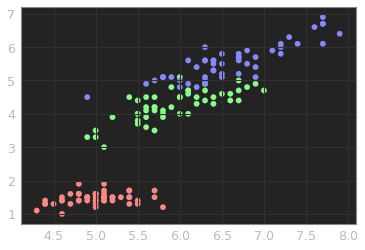

x - 花びらの長さ 
y - がくの幅


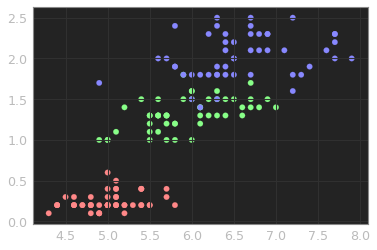

x - 花びらの幅 
y - がくの長さ


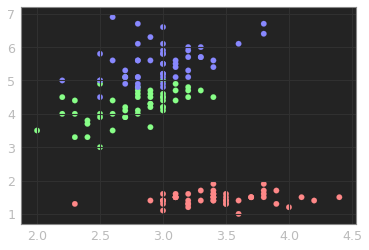

x - 花びらの幅 
y - がくの幅


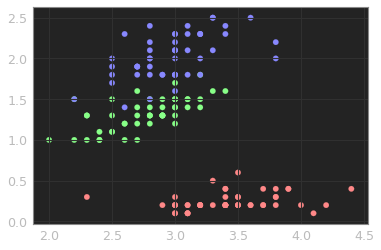

x - がくの長さ 
y - がくの幅


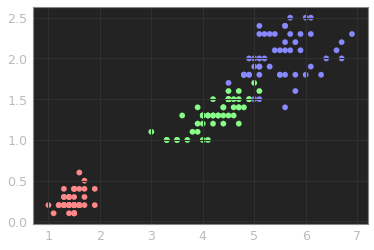

In [22]:
#正規化してないのでデータセットにはできないが、表示の簡便化のためとりあえずTupleDatasetにする
dataset = datasets.TupleDataset(data.data, data.target)

feat = ['花びらの長さ', '花びらの幅', 'がくの長さ', 'がくの幅']

for i in range(4):
    for j in range(4):
        if not j > i: continue        
        print("x -",feat[i],"\ny -", feat[j])
        PlotTupleDataSet(dataset, ["#FF8888", "#88FF88", "#8888FF"], i, j)
        plt.show()
        

## データの前処理

データは正規化されていないので正規化する

今回はそれぞれの特徴で、(値-最小値)/(最大値-最小値)で全てのデータを[0,1]におさめる

各特徴の最大値-最小値の出し方を以下に示す

In [24]:
maxs = np.max(data.data, axis=0)
mins = np.min(data.data, axis=0)
scales = maxs - mins

maxs
mins
scales

array([ 7.9,  4.4,  6.9,  2.5])

array([ 4.3,  2. ,  1. ,  0.1])

array([ 3.6,  2.4,  5.9,  2.4])

この時、scalesが各特徴での最大値-最小値を表す

In [25]:
data.data = (data.data-mins)/scales

data.data

array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
       [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
       [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
       [ 0.19444444,  0.66666667,  0.06779661,  0.04166667],
       [ 0.30555556,  0.79166667,  0.11864407,  0.125     ],
       [ 0.08333333,  0.58333333,  0.06779661,  0.08333333],
       [ 0.19444444,  0.58333333,  0.08474576,  0.04166667],
       [ 0.02777778,  0.375     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.45833333,  0.08474576,  0.        ],
       [ 0.30555556,  0.70833333,  0.08474576,  0.04166667],
       [ 0.13888889,  0.58333333,  0.10169492,  0.04166667],
       [ 0.13888889,  0.41666667,  0.06779661,  0.        ],
       [ 0.        ,  0.41666667,  0.01694915,  0.        ],
       [ 0.41666667,  0.83333333,  0.03389831,  0.04166667],
       [ 0.38888889,  1.        ,  0.08474576,  0.125     ],
       [ 0.30555556,  0.

## モデルの用意

今回はSimpleModel（Chainer Sample MNIST と同じ）を使う

In [5]:
#モデルを用意
class SimpleModel(Chain):
    def __init__(self, n_out):
        super(SimpleModel, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, n_out)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

## データセット作成

In [14]:
# datasetのデフォルトはfloat64のnumpy.ndarrayなので計算用に型変換する
dataset = datasets.TupleDataset(data.data.astype(np.float32), data.target)
#テストデータは全体の1/4程度とする
test_len = int(len(dataset)/4)
print("test dataset length:",test_len)

test, train = datasets.split_dataset_random(dataset, test_len)

batch_size = 5

train_iter = iterators.SerialIterator(train, batch_size)
test_iter = iterators.SerialIterator(test, batch_size, False, False)

test dataset length: 37


## trainerの作成・学習

In [18]:
def GetTrainerForModel(model, train_iter, test_iter, stop_epoch, log_name):
        optimizer = optimizers.Adam()
        classifier = L.Classifier(model)
        optimizer.setup(classifier)
        updater = training.StandardUpdater(train_iter, optimizer)
        trainer = training.Trainer(updater, (stop_epoch, 'epoch'))
        
        trainer.extend(extensions.Evaluator(test_iter, classifier))
        trainer.extend(extensions.LogReport(log_name=log_name))
        trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'elapsed_time']))
        return trainer

model = SimpleModel(3)

trainer = GetTrainerForModel(model, train_iter, test_iter, 200, 'trainLog_Iris')



In [19]:
#学習スタート
train_iter.reset()
test_iter.reset()
trainer.run()

epoch       main/accuracy  main/loss   elapsed_time
1           0.73913        0.815386    0.0460441     
2           0.73913        0.486462    0.105487      
3           0.781818       0.393213    0.156511      
4           0.86087        0.296998    0.210547      
5           0.945455       0.231521    0.267598      
6           0.956522       0.19025     0.324627      
7           0.956522       0.15896     0.386673      
8           0.936364       0.188668    0.444713      
9           0.965217       0.134001    0.511801      
10          0.954545       0.129673    0.563836      
11          0.956522       0.113041    0.619258      
12          0.93913        0.143111    0.672296      
13          0.945455       0.145787    0.726322      
14          0.93913        0.133212    0.783374      
15          0.954545       0.106017    0.842404      
16          0.956522       0.117807    0.909453      
17          0.947826       0.124011    0.968494      
18          0.972727       0.0

result/trainLog_Iris
2017-10-29 14:20:51


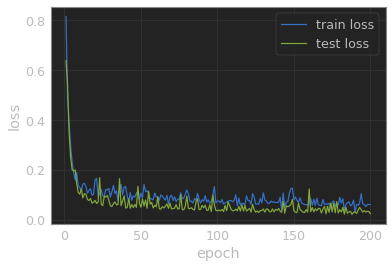

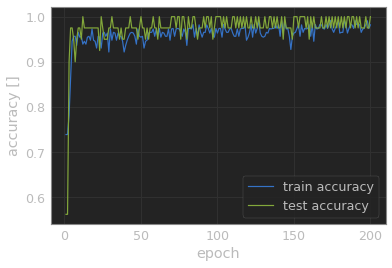

In [20]:
PlotLossAndAccuracy('result', 'trainLog_Iris')